In [1]:
import librosa
import librosa.display
from IPython.display import Audio
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pandas as pd
import numpy as np
from fastai.vision.all import *

In [2]:
DATA = Path('../../data')
URBAN_SOUND = DATA/'urban-sound'
URBAN_SOUND_RECORDINGS = URBAN_SOUND/'data'
#AUDIO_RECORDINGS = AUDIO_TAGGING/'audio_train'

In [3]:
dst_path = URBAN_SOUND/'train'
dst_path.mkdir(exist_ok=True)

In [4]:
URBAN_SOUND.ls()

(#5) [Path('../../data/urban-sound/train'),Path('../../data/urban-sound/data'),Path('../../data/urban-sound/FREESOUNDCREDITS.txt'),Path('../../data/urban-sound/.DS_Store'),Path('../../data/urban-sound/UrbanSound_README.txt')]

In [5]:
URBAN_SOUND_RECORDINGS.ls()

(#10) [Path('../../data/urban-sound/data/car_horn'),Path('../../data/urban-sound/data/jackhammer'),Path('../../data/urban-sound/data/siren'),Path('../../data/urban-sound/data/street_music'),Path('../../data/urban-sound/data/engine_idling'),Path('../../data/urban-sound/data/gun_shot'),Path('../../data/urban-sound/data/drilling'),Path('../../data/urban-sound/data/dog_bark'),Path('../../data/urban-sound/data/children_playing'),Path('../../data/urban-sound/data/air_conditioner')]

In [6]:
from pydub import AudioSegment
from pydub.utils import which

AudioSegment.converter = which("ffmpeg")

In [33]:
children_playing = URBAN_SOUND_RECORDINGS/'street_music'
children_playing.ls()
sound = AudioSegment.from_file(children_playing/'7390.mp3')
print(f'Duration before cut: {sound.duration_seconds}')
s = sound[:10000]
s.export(children_playing/'test.mp3', format='mp3')
sound = AudioSegment.from_file(children_playing/'test.mp3')
print(f'Duration after cut: {sound.duration_seconds}')

Duration before cut: 20.0
Duration after cut: 10.0


import ffmpeg  
children_playing = URBAN_SOUND_RECORDINGS/'street_music'
ffmpeg.audio.a_split()
audio_input = ffmpeg.input(children_playing/'7390.mp3')
audio_cut = audio_input.audio.filter('atrim', duration=5)
audio_output = ffmpeg.output(audio_cut, 'out.mp3')
ffmpeg.run(audio_output)

In [8]:
for subdir, dirs, files in os.walk(URBAN_SOUND_RECORDINGS): ## cin
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file
        source_path = Path(subdir)
        #print(filepath)
        #print(file)

        if filepath.endswith('.mp3'):
            sound = AudioSegment.from_file(filepath)
            sound.export(filepath, 'wav')

In [9]:
import soundfile as sf

In [10]:
f = sf.SoundFile(children_playing/'7390.mp3')
f.format, f.subtype, f.endian

('WAV', 'PCM_16', 'FILE')

In [11]:
count = 0
numRemoved = 0
for subdir, dirs, files in os.walk(URBAN_SOUND_RECORDINGS):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file
        source_path = Path(subdir)
        #print(filepath)
        #print(file)

        if not filepath.endswith(('.csv', '.json','.DS_Store','.aif','.flac')):
            try:
                f = sf.SoundFile(filepath)
            except:
                os.remove(filepath) # Remove files with unsupoorted format
                numRemoved += 1
                print(f'Removed file: {file} \n Removed files: {numRemoved}', end='/r')
            else:
                try:
                    sound = AudioSegment.from_file(filepath)
                    file_format = file.split(".")[-1]
                    if sound.duration_seconds > 20:
                        first_twenty = sound[:20000]
                        first_twenty.export(filepath, format=file_format)
                        count += 1
                        print(f'Converted audio clips: {count}', end='\r')
                except:
                    os.remove(filepath)
                    numRemoved += 1
                    print(f'Removed files: {numRemoved}', end='\r')
        else:
            os.remove(filepath)
            numRemoved += 1
            print(f'Removed files: {numRemoved}', end='\r')

In [12]:
def log_mel_spec_tfm(fname, label, src_path , dst_path):
    data, sample_rate = librosa.load(src_path/fname)
    
    n_fft = 1024
    hop_length = 512
    n_mels = 80
    fmin = 20
    fmax = sample_rate / 2 
    
    mel_spec_power = librosa.feature.melspectrogram(data, sr=sample_rate, n_fft=n_fft, 
                                                    hop_length=hop_length, 
                                                    n_mels=n_mels, power=2.0, 
                                                    fmin=fmin, fmax=fmax)
    
    #mel_spec_power = librosa.feature.melspectrogram(x, sr=sample_rate)
    
    mel_spec_db = librosa.power_to_db(mel_spec_power, ref=np.max)
        
    dst_path = dst_path / label
    dst_path.mkdir(exist_ok=True)
    
    dst_fname = dst_path / (fname[:-4] + '.png')
    #print(dst_fname)
    plt.imsave(dst_fname, mel_spec_db)

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
def convert_to_spec():
    count = 0
    for subdir, dirs, files in os.walk(URBAN_SOUND_RECORDINGS):
        for file in files:
            #print os.path.join(subdir, file)
            filepath = subdir + os.sep + file
            source_path = Path(subdir)
            #print(filepath)
            #print(file)
            count += 1
            if count % 10 == 0:
                print(count, end='\r')
            label = subdir.split("/")[-1]
            #print(label)
            log_mel_spec_tfm(file, label, source_path, dst_path)

In [25]:
#convertto_spec()

In [15]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [16]:
dls = dblock.dataloaders(dst_path)

In [17]:
modelPath = Path('../models')
preTrained = load_learner(modelPath/'model_V1.pkl')

In [18]:
def get_model(model, pretrained=True):
    m = model
    return m

In [19]:
model = partial(get_model, model=preTrained.model)
m = model()
type(m)

torch.nn.modules.container.Sequential

In [20]:
learn = cnn_learner(dls, model, metrics=[error_rate, accuracy])

In [21]:
#learn.load("sound_model_V1")

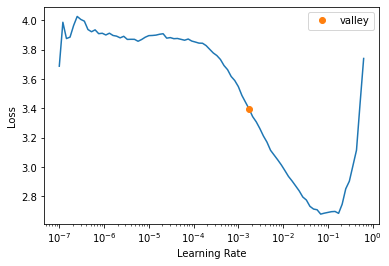

In [22]:
lr = learn.lr_find()

In [23]:
lrate = lr.valley

In [24]:
learn.fine_tune(8, lrate)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.997634,2.832581,0.709251,0.290749,00:01


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.847581,1.622106,0.511013,0.488987,00:01
1,1.739364,1.221170,0.418502,0.581498,00:01
2,1.600363,1.174479,0.365639,0.634361,00:01
3,1.497365,1.158192,0.356828,0.643172,00:01
4,1.381525,1.118704,0.334802,0.665198,00:01
5,1.320506,1.099458,0.348018,0.651982,00:01
6,1.271123,1.087910,0.343612,0.656388,00:01
7,1.223706,1.088961,0.348018,0.651982,00:01


In [26]:
interp = Interpretation.from_learner(learn)

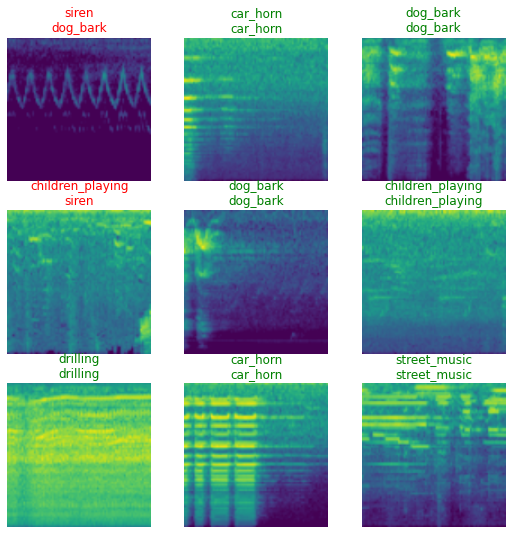

In [27]:
learn.show_results()

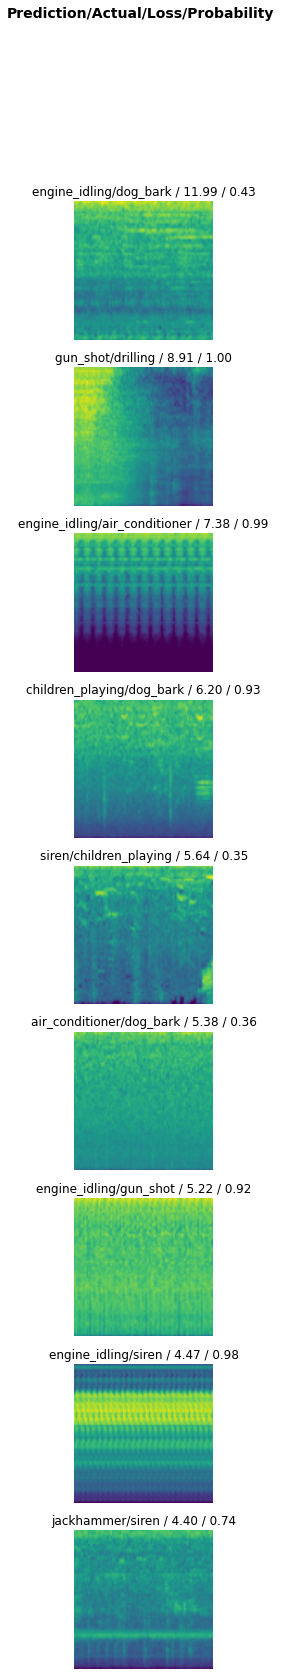

In [30]:
interp.plot_top_losses(9,nrows=9)

In [31]:
a = ClassificationInterpretation.from_learner(learn)

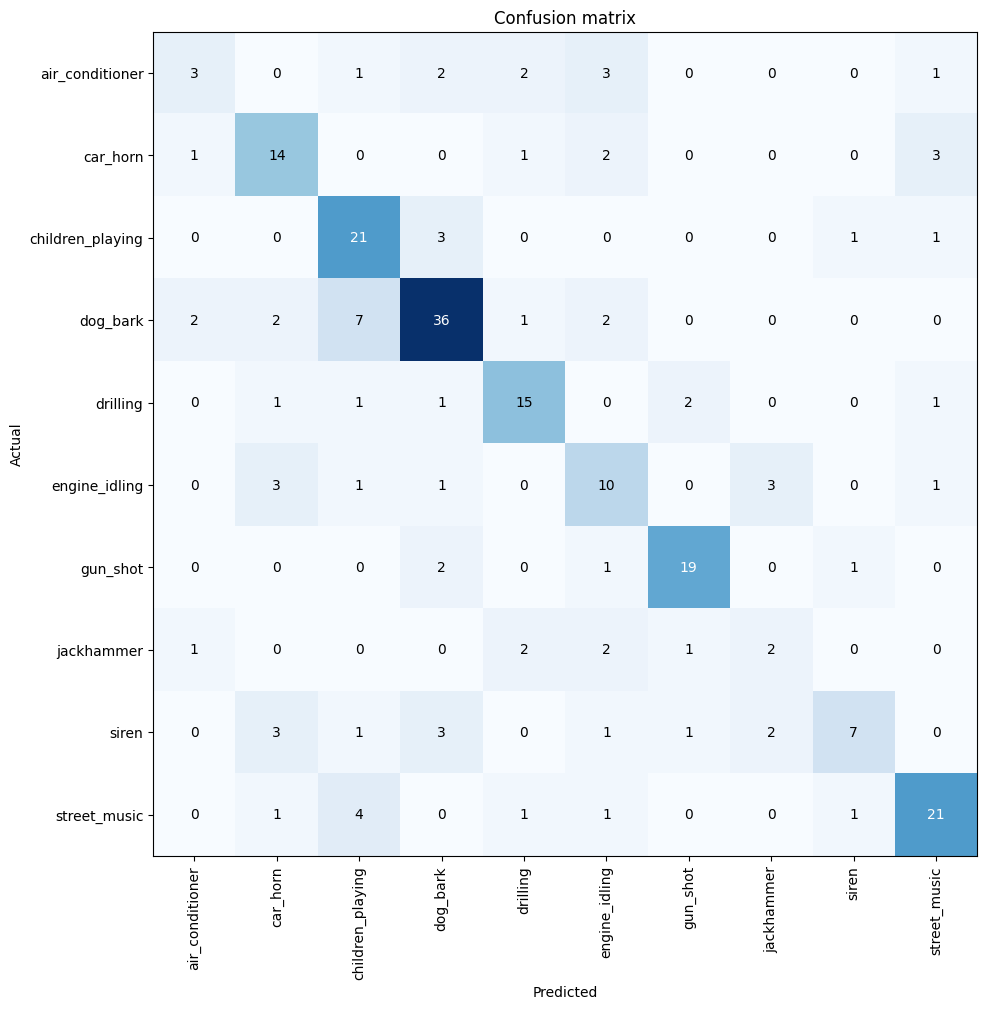

In [32]:
a.plot_confusion_matrix(figsize=(10,10), dpi = 100)